### This notebook is dedicated to classifying trajectories

In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import types
import time
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter


ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run Lesion_Size.ipynb
# %run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

param={
    'treadmillRange':(0,90),
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

In [ ]:
class TwoTailPermTest:
    """
    Permutation test as to whether there is significant difference between group one and two.
    
    group1, group2: Represent the data. they could be either one dimentional (several realizations)
        or 2-D (several realizaions through out the time/space/... course)
        EX: x.shape==(15,500) means 15 trials/samples over 500 time bins

    nIterations: Number of iterations used to shuffle. max(iterN)=(len(x)+len(y))!/len(x)!len(y)!

    initGlobConfInterval:
        Initial value for the global confidence band.

    smoothSigma: the standard deviation of the gaussian kernel used for smoothing when there are multiple data points,
        based on the Fujisawa 2008 paper, default value: 0.05

    Outputs:
        pVal: P-values
        highBand, lowBand: AKA boundary. Represents global bands.
        significantDiff: An array of True or False, indicating whether there is a difference.
    
    """  
    def __init__(self, group1, group2, nIterations=1000, initGlobConfInterval=5, smoothSigma=0.05, randomSeed=1):
        self.__group1, self.__group2 = self.__setGroupData(group1), self.__setGroupData(group2)
        self.__nIterations, self.__smoothSigma = nIterations, smoothSigma
        self.__initGlobConfInterval = initGlobConfInterval
        self.__randomSeed = randomSeed
        
        self.__checkGroups()

        # origGroupDiff is also known as D0 in the definition of permutation test.
        self.__origGroupDiff = self.__computeGroupDiff(group1, group2)

        # Generate surrogate groups, compute difference of mean for each group, and put in a matrix.
        self.__diffSurGroups = self.__setDiffSurrGroups()

        # Set statistics
        self.pVal = self.__setPVal()
        self.highBand, self.lowBand = self.__setBands()
        self.pairwiseHighBand = self.__setPairwiseHighBand()
        self.pairwiseLowBand = self.__setPairwiseLowBand()
        self.significantDiff = self.__setSignificantGroup()

    def __setGroupData(self, groupData):
        if not isinstance(groupData, dict):
            return groupData

        realizations = list(groupData.values())
        subgroups = list(groupData.keys())
                    
        dataMat = np.zeros((len(subgroups), len(realizations[0])))
        for index, realization in enumerate(realizations):
            if len(realization) != len(realizations[0]):
                raise Exception("The length of all realizations in the group dictionary must be the same")
            
            dataMat[index] = realization

        return dataMat

    def __checkGroups(self):
        # input check
        if not isinstance(self.__group1, np.ndarray) or not isinstance(self.__group2, np.ndarray):
            raise ValueError("In permutation test, \"group1\" and \"group2\" should be numpy arrays.")

        if self.__group1.ndim > 2 or self.__group2.ndim > 2:
            raise ValueError('In permutation test, the groups must be either vectors or matrices.')

        elif self.__group1.ndim == 1 or self.__group2.ndim == 1:
            self.__group1 = np.reshape(self.__group1, (len(self.__group1), 1))
            self.__group2 = np.reshape(self.__group2, (len(self.__group2), 1))

    def __computeGroupDiff(self, group1, group2):
        meanDiff = np.nanmean(group1, axis=0) - np.nanmean(group2, axis=0)
        
        if len(self.__group1[0]) == 1 and len(self.__group2[0]) == 1:
            return meanDiff
        
        return smooth(meanDiff, sigma=self.__smoothSigma)

    def __setDiffSurrGroups(self):
        # Fix seed 
        np.random.seed(seed=self.__randomSeed)
        # shuffling the data
        self.__concatenatedData = np.concatenate((self.__group1,  self.__group2), axis=0)
        
        diffSurrGroups = np.zeros((self.__nIterations, self.__group1.shape[1]))
        for iteration in range(self.__nIterations):
            # Generate surrogate groups
            # Shuffle every column.
            np.random.shuffle(self.__concatenatedData)  

            # Return surrogate groups of same size.            
            surrGroup1, surrGroup2 = self.__concatenatedData[:self.__group1.shape[0], :], self.__concatenatedData[self.__group1.shape[0]:, :]
            
            # Compute the difference between mean of surrogate groups
            surrGroupDiff = self.__computeGroupDiff(surrGroup1, surrGroup2)
            
            # Store individual differences in a matrix.
            diffSurrGroups[iteration, :] = surrGroupDiff

        return diffSurrGroups
 
    def __setPVal(self):
        positivePVals = np.sum(1*(self.__diffSurGroups > self.__origGroupDiff), axis=0) / self.__nIterations
        negativePVals = np.sum(1*(self.__diffSurGroups < self.__origGroupDiff), axis=0) / self.__nIterations
        return np.array([np.min([1, 2*pPos, 2*pNeg]) for pPos, pNeg in zip(positivePVals, negativePVals)])

    def __setBands(self):
        if not isinstance(self.__origGroupDiff, np.ndarray):  # single point comparison
            return None, None
        
        alpha = 100 # Global alpha value
        highGlobCI = self.__initGlobConfInterval  # global confidance interval
        lowGlobCI = self.__initGlobConfInterval  # global confidance interval
        while alpha >= 5:
            # highBand = np.percentile(a=self.__diffSurGroups, q=100-highGlobCI, axis=0)
            # lowBand = np.percentile(a=self.__diffSurGroups, q=lowGlobCI, axis=0)

            highBand = np.percentile(a=self.__diffSurGroups, q=100-highGlobCI)
            lowBand = np.percentile(a=self.__diffSurGroups, q=lowGlobCI)

            breaksPositive = np.sum(
                [np.sum(self.__diffSurGroups[i, :] > highBand) > 1 for i in range(self.__nIterations)]) 
            
            breaksNegative = np.sum(
                [np.sum(self.__diffSurGroups[i, :] < lowBand) > 1 for i in range(self.__nIterations)])
            
            alpha = ((breaksPositive + breaksNegative) / self.__nIterations) * 100
            highGlobCI = 0.95 * highGlobCI
            lowGlobCI = 0.95 * lowGlobCI
        return highBand, lowBand           

    def __setSignificantGroup(self):
        if not isinstance(self.__origGroupDiff, np.ndarray):  # single point comparison
            return self.pVal <= 0.05

        # finding significant bins
        globalSig = np.logical_or(self.__origGroupDiff > self.highBand, self.__origGroupDiff < self.lowBand)
        pairwiseSig = np.logical_or(self.__origGroupDiff > self.__setPairwiseHighBand(), self.__origGroupDiff < self.__setPairwiseLowBand())
        
        significantGroup = globalSig.copy()
        lastIndex = 0
        for currentIndex in range(len(pairwiseSig)):
            if (globalSig[currentIndex] == True):
                lastIndex = self.__setNeighborsToTrue(significantGroup, pairwiseSig, currentIndex, lastIndex)

        return significantGroup
    
    def __setPairwiseHighBand(self, localBandValue=0.5):        
        return np.percentile(a=self.__diffSurGroups, q=100 - localBandValue, axis=0)

    def __setPairwiseLowBand(self, localBandValue=0.5):        
        return np.percentile(a=self.__diffSurGroups, q=localBandValue, axis=0)

    def __setNeighborsToTrue(self, significantGroup, pairwiseSig, currentIndex, previousIndex):
        """
            While the neighbors of a global point pass the local band (consecutively), set the global band to true.
            Returns the last index which was set to True.
        """ 
        if (currentIndex < previousIndex):
            return previousIndex
        
        for index in range(currentIndex, previousIndex, -1):
            if (pairwiseSig[index] == True):
                significantGroup[index] = True
            else:
                break

        previousIndex = currentIndex
        for index in range(currentIndex + 1, len(significantGroup)):
            previousIndex = index
            if (pairwiseSig[index] == True):
                significantGroup[index] = True
            else:
                break
        
        return previousIndex
    
    def plotSignificant(self,ax: plt.Axes.axes,y: float,x=None,**kwargs):
        if x is None:
            x=np.arange(0,len(self.significantDiff))+1
        for x0,x1,p in zip(x[:-1],x[1:],self.significantDiff):
            if p:
                ax.plot([x0,x1],[y,y],zorder=-2,**kwargs)
                
    @staticmethod
    def plotSigPair(ax: plt.Axes.axes,y: float,x=None, s: str ='*',**kwargs):
        if x is None:
            x=(0,len(self.significantDiff))
        if 'color' not in kwargs:
            kwargs['color']='k'
        
        dy=.03*(ax.get_ylim()[1]-ax.get_ylim()[0])
        ax.plot(x,[y,y],**kwargs)
        ax.plot([x[0],x[0]],[y-dy,y],[x[1],x[1]],[y-dy,y],**kwargs)
        ax.text(np.mean(x),y,s=s,
                ha='center',va='center',color=kwargs['color'],
                size='medium',fontstyle='italic',backgroundcolor='w')

---

**initial position analysis**

In [ ]:
def initial_pos(root, profile, animalList, SessionRange, trdBins):
    def et_and_initial_pos(data):
        
        et     =data.entranceTime
        initPos=np.array([data.position[i][data.startFrame[i]] for i in data.position])
        gt     =np.nanmedian(data.goalTime)

        if len(et)==len(initPos):
            return et,initPos,gt
        else:
            return None,None,None
    
    PerfParam=[et_and_initial_pos]
    initialPos=dict()
    countN=0
    for animal in  animalList:
        sessions=batch_get_session_list(root,[animal],profile=profile)['Sessions']
        data=data_fetch(root, animal=animal, profile=profile,
                        PerfParam= PerfParam,
                        NbSession=100)[PerfParam[0].__name__]
        
        data=data[SessionRange[0]:SessionRange[1]]
        initialPos[animal]=[]
        for et,pos,gt in data:
            if et is None:
                countN+=1
                continue
            initialPos[animal].extend(list(pos[et<=16]))
        
        initialPos[animal]=np.array(initialPos[animal])
    
    logging.warning(f'{countN} sessions were removed, entranceTime != position')
    
    return initialPos
    
def probablity_initial_pos(root,profile,animalList, SessionRange, trdBins=range(0,91,1), TH=30):
        
    initialPos= initial_pos(root, profile, animalList, SessionRange, trdBins)
    
    X=np.array(trdBins[1:])-trdBins.step/2
    initPosTH=[]

    for animal in animalList:
        data=initialPos[animal][~np.isnan(initialPos[animal])]
        pdf,_=np.histogram(data, trdBins, density=True)
        cumu=np.cumsum(pdf)
        
        assert len(X)==len(cumu), 'problemo!'
        y=cumu[X>=TH][0]
        initPosTH.append(y)
        
    return np.array(initPosTH)

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':['10'],
             'Tag':'Control'
                  }
    animalList1=batch_get_animal_list(root,profile)
#     animalList=animalList[10:12]

    SessionRange=[20,30]
    
    ctrlInit=probablity_initial_pos(root,profile,animalList1, SessionRange)
    

In [ ]:
if "__file__" not in dir():
    AnimalProfile={'Type':'Good',
#          'option': ['not used'],
         'rewardType':'Progressive',
         'initialSpeed':['10','0'],
         'Speed':'10',
         'Tag':['Early-Lesion_DS','Early-Lesion_DMS','Early-Lesion_DLS']
                  }
    
    animalList2=batch_get_animal_list(root,AnimalProfile)
    
    SessionRange=[20,30]
    
    LesionInit=probablity_initial_pos(root,AnimalProfile,animalList2, SessionRange)

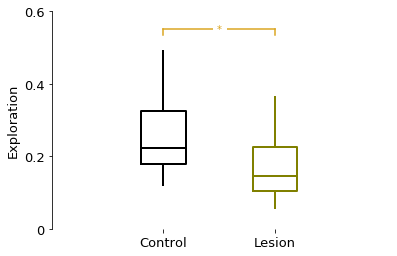

In [122]:
if "__file__" not in dir():
    c=ctrlInit[~np.isnan(ctrlInit)]
    l=LesionInit[~np.isnan(LesionInit)]
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    for i,(data,color) in enumerate(zip((1-c,1-l),('k','olive'))):
        ax.boxplot(x=data,whis=[5,95],
                  positions=[i], widths=.4,
                  showcaps=False, showfliers=False,
                  medianprops={'color':color,'linewidth':2},
                   boxprops={'color':color,'linewidth':2},
                   whiskerprops={'color':color,'linewidth':2},
                  zorder=1)


    test=TwoTailPermTest(group1=np.array(c), group2=np.array(l), nIterations=10000)
    s='*' if test.significantDiff[0] else 'n.s.'
    test.plotSigPair(ax,y=.55,x=(0,1), s=s, color='goldenrod',lw=1.5)

    
    ax.set_xlim([-1,2])
    ax.set_ylabel('Exploration',fontdict=font)
    ax.set_xticks([0,1])
    ax.set_yticks([0,.2,.4,.6])
    ax.set_xticklabels(['Control','Lesion'],fontdict=font)
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

#     fig.savefig('/home/david/Mostafa/PhD/iBAGS2019/DavidTalk/earlyBox.pdf')

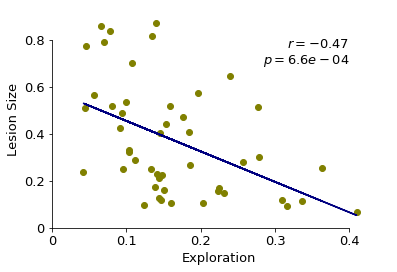

In [123]:
if "__file__" not in dir():
    lesionSize=[]
    lesionExp=[]
    for i,animal in enumerate(animalList2):
        if np.isnan(LesionInit[i]):
            continue
        try:
            f=HistologyExcel('/NAS02',animal)
            tmp=f.lesion_size()
        except:
            logging.warning(f'animal with excel problem: {animal}')
            continue
        lesionSize.append(tmp)
        lesionExp.append(1-LesionInit[i])
        
    
    lesionSize=np.array(lesionSize)
    lesionExp=np.array(lesionExp)

    lesionSize=lesionSize[lesionExp<.45]
    lesionExp=lesionExp[lesionExp<.45]
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.scatter(lesionExp,lesionSize,c='olive')
    
    r,p=scipy.stats.pearsonr(lesionExp,lesionSize)
    P = np.poly1d(np.polyfit(lesionExp, lesionSize, 1))
    ax.plot(lesionExp,P(lesionExp),'navy')
    
    ax.set_xlim([0,.45])
    ax.set_xlabel('Exploration',fontdict=font)
    ax.set_ylabel('Lesion Size',fontdict=font)
    ax.set_xticklabels(ax.get_xticks(),fontdict=font)
    ax.set_yticklabels(ax.get_yticks(),fontdict=font)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,.1,.2,.3,.4])
    ax.set_yticks([0,.2,.4,.6,.8])
    ax.spines['bottom'].set_bounds(0,.4)
    ax.spines['left'].set_bounds(0,.8)
    
    s='$r=$'+'$%+.2f$'%(r)+'\n'+'$p=$'+'$%.1e$'%(p)
    ax.text(x=.4, y=.8, s=s, ha='right', va='top', fontsize=13)

#     fig.savefig('/home/david/Mostafa/PhD/iBAGS2019/DavidTalk/early.pdf')

Plotting a matrix of all session trajectories

In [ ]:
def plot_batch_traj(root='/data', axes=None, columnNb=5, animal='Rat166', profile={}, stop_date=''):
    if type(animal) != str:
        raise("enter the name of a single animal")
        
    sessionList=batch_get_session_list(root,animalList=[animal],profile=profile,until_date=stop_date)['Sessions'][:]
    if sessionList:
        rowNb=(len(sessionList)//columnNb) +1
        if axes is None:
            fig=plt.figure(figsize=(16,16),dpi=75,tight_layout=False)
            fig.suptitle(animal,y=.95)
            axes=[fig.add_subplot(rowNb,columnNb,i+1) for i,_ in enumerate(sessionList)]
    for i,session in enumerate(sessionList):
        data=Data(root,session[:6],session,redoPreprocess=False)
        ax=axes[i]
        try:
            plot_positions(data,onlyGood=False,raw=False,vSpan=False,axis=ax,linewidth=.5)
            ax.set_title('Session '+str(i+1))
            ax.set_axis_off()
        except Exception as e:
            print(repr(e))            

    return sessionList

In [ ]:
if "__file__" not in dir():
    AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':'10',
     'Speed':'10',
     'Tag':['Control']
                  }
    animal="Rat166"
    ColumnNb=5
    _,a=plot_batch_traj(root='/data', columnNb=ColumnNb, animal=animal, profile=AnimalProfile, stop_date='')
    a.savefig('/home/david/Mostafa/1.png')

PCA on Trajectory

In [ ]:
def position_based_trajectory(root,animalList,SESSION_LIMIT,MAX_L):
    traj=[]
    
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]

        for session in tmp:
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            try:
                with open(picklePath,'rb') as f:
                    data=pickle.load(f)
                traj.extend([data['position'][i] for i in data['position']])

            except:pass
    Traj=np.ones((MAX_L,len(traj)))*np.nan

    for i,pos in enumerate(traj):
        Traj[:min(len(pos),MAX_L),i]=pos[:min(len(pos),MAX_L)]
        
    return Traj



AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10'],
     'Speed':['10'],
     'Tag':'Control'
              }

animalList=batch_get_animal_list(root,AnimalProfile)

SESSION_LIMIT=5  #don't change the sign
MAX_L        =200
Traj=position_based_trajectory(root,animalList,SESSION_LIMIT,MAX_L)
Traj=Traj.T
print(np.max(np.sum(np.isnan(Traj),axis=1)))
data0=mlab.PCA(Traj)
naive1=data0.Y[:,0]
naive2=data0.Y[:,1]
naive3=data0.Y[:,2]
SESSION_LIMIT=-SESSION_LIMIT
Traj=position_based_trajectory(root,animalList,SESSION_LIMIT,MAX_L)
Traj=Traj.T
print(np.max(np.sum(np.isnan(Traj),axis=1)))
data1=mlab.PCA(Traj)
trained1=data1.Y[:,0]
trained2=data1.Y[:,1]
trained3=data1.Y[:,2]

In [ ]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':['Control']
        }
animalList=batch_get_animal_list(root,profile)
print(animalList)

In [ ]:
obj=sample_size_control(get_rat_group_statistic,animalList,NbAnimal=5,n=30,root=root,profile=profile,parameter=param,
                                                           redo=False,stop_dayPlot=30,TaskParamToPlot=["% good trials on last 40"])

In [ ]:
obj.Results[25][0]['% good trials on last 40'].keys()
plt.plot(obj.animalRepeat,'-*')

In [ ]:
#%matplotlib inline
plt.figure()
plt.boxplot((naive1,trained1));


In [ ]:
#%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(naive1,naive2,naive3,c='b',marker='.',alpha=.5,label='Naive')
ax.scatter(trained1,trained2,trained3,c='r',marker='.',alpha=.5,label='Trained')
plt.xlabel('1')
plt.ylabel('2')
#plt.zlabel('3')
#plt.xlim([7,8])
# plt.ylim([0,90])
plt.legend();

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.gca().set_ylim([-.1,.1])
i=3
plt.plot(data0.Wt.T[:,:i]);
plt.subplot(1,2,2)
plt.plot(data1.Wt.T[:,:i]);
plt.gca().set_ylim([-.1,.1])

In [ ]:
#Traj=Traj.T
print(np.max(np.sum(np.isnan(Traj),axis=1)))
data=mlab.PCA(Traj)
plt.plot(data.s[:15]/np.sum(data.s[:15]),'.')

PCA on whole data and then display only first and last sessions

In [ ]:
def position_based_trajectory2(root,animalList,SESSION_LIMIT,MAX_L):
    traj=[]
    ID=[]
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        tmp1=sorted(sessionDict['Sessions'])[:abs(SESSION_LIMIT)]
        tmp2=sorted(sessionDict['Sessions'])[-abs(SESSION_LIMIT):]

        for session in sorted(sessionDict['Sessions']):
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            try:
                with open(picklePath,'rb') as f:
                    data=pickle.load(f)
                traj.extend([data['position'][i] for i in data['position']])
                if session in tmp1:
                    ID.extend(['naive' for i in data['position']])
                elif session in tmp2:
                    ID.extend(['trained' for i in data['position']])
                else:
                    ID.extend(['blah' for i in data['position']])

            except:pass
    Traj=np.ones((MAX_L,len(traj)))*np.nan

    for i,pos in enumerate(traj):
        Traj[:min(len(pos),MAX_L),i]=pos[:min(len(pos),MAX_L)]
        if len(pos) < MAX_L:
            Traj[np.isnan(Traj[:,i]),i]=Traj[np.where(np.isnan(Traj[:,i]))[0][0]-1,i]
    
    return Traj,ID

AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10'],
     'Speed':['10'],
     'Tag':'Control'
              }

animalList=batch_get_animal_list(root,AnimalProfile)

SESSION_LIMIT=5
MAX_L        =375
COMPONENT=0

Traj,ID=position_based_trajectory2(root,animalList,SESSION_LIMIT,MAX_L)
Traj=Traj.T
print(np.max(np.sum(np.isnan(Traj),axis=1)))
data=mlab.PCA(Traj)

plt.boxplot((data.Y[np.array(ID)=='naive',COMPONENT],data.Y[np.array(ID)=='trained',COMPONENT]),labels=['naive','trianed']);
plt.gca().set_title('components\' evolution through learning\ncomponent:%s'%str(COMPONENT+1));

In [ ]:
COMPONENT=10
scipy.stats.kruskal(data.Y[np.array(ID)=='naive',COMPONENT],data.Y[np.array(ID)=='trained',COMPONENT])

In [ ]:
fig=plt.figure(figsize=(10,5))
i=3
plt.subplot(1,2,1)
plt.plot(data.Wt.T[:,:i]);
plt.subplot(1,2,2)
plt.plot(data.Wt.T[:,:i]);